17K Mobile Strategy Games10

In [1]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

## Models :
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
pd.set_option('display.max_columns', None) # allows to display all columns of the df

In [3]:
import os

import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("D:/Medium/17K Mobile Strategy Games/appstore games.csv")

In [5]:
df[:3]

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017


As we only need our two variables of interest, we can drop the others :

In [6]:
df = df.filter(["Age Rating","Description"])
df[:3]

,Age Rating,Description
0,4+,"Join over 21,000,000 of our fans and download ..."
1,4+,"The classic game of Reversi, also known as Oth..."
2,4+,Play the classic strategy game Othello (also k...


Before beginning the pre-processing phase, we can just quickly have a look at the observations, with some descriptive statistics :

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Age Rating   17007 non-null  object
 1   Description  17007 non-null  object
dtypes: object(2)
memory usage: 265.9+ KB


A first good point is that there are no missing values, both for the age rating and for the descriptions. The dataset is composed of 17.007 observations. We can have a look at the possible values for the target variable Age Rating :

In [8]:
print("Number of Age Rating classes : " +str(df["Age Rating"].nunique()))
print("Labels :" + str(np.unique(list(df["Age Rating"].values))))

Number of Age Rating classes : 4
Labels :['12+' '17+' '4+' '9+']


The Age Rating target is composed of 4 classes, so we are in a context of Multi-Label Classification. We can also analyse the representation of each label in this dataset :

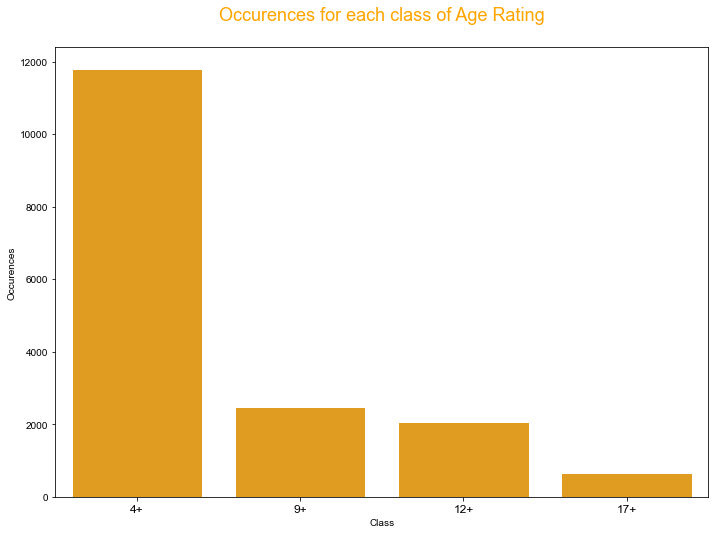

In [9]:
labels_freqs = df.groupby("Age Rating")["Description"]\
            .count()\
            .to_frame()\
            .reset_index()\
            .sort_values("Description", ascending = False)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.set_theme(style = "whitegrid")
ax = sns.barplot(x = labels_freqs["Age Rating"], y = labels_freqs["Description"], color = "orange")
ax.set(xlabel = "Class", ylabel = "Occurences")
plt.xticks(rotation = 0, size = 12, weight = 'normal')
plt.title("Occurences for each class of Age Rating\n", fontsize=18, color= "orange")
plt.show()

We clearly see that there is a significant difference of representation between the different classes of the Age Rating : the class "4+" is highly represented, unlike the class "17+". More generally, there is a negative correlation between the number of observations and the age associated to the class. This phenomenon is quite intuitive as we can imagine that a higher age limit is less interesting for app creators by the fact that it is more restrictive.

We can now compute the average number of words for the descriptions of each class :

In [10]:
df["words_count"] = df.Description.apply(lambda x : len(x.split()))
df[:3]

,Age Rating,Description,words_count
0,4+,"Join over 21,000,000 of our fans and download ...",259
1,4+,"The classic game of Reversi, also known as Oth...",204
2,4+,Play the classic strategy game Othello (also k...,97


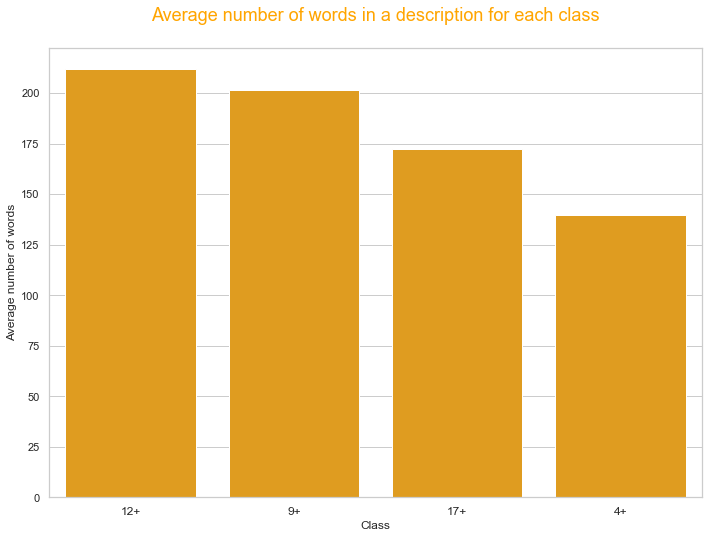

In [11]:
average_lenght = df.groupby("Age Rating")["words_count"]\
            .mean()\
            .to_frame()\
            .reset_index()\
            .sort_values("words_count", ascending = False)


fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.set_theme(style = "whitegrid")
ax = sns.barplot(x = average_lenght["Age Rating"], y = average_lenght["words_count"], color = "orange")
ax.set(xlabel = "Class", ylabel = "Average number of words")
plt.xticks(rotation = 0, size = 12, weight = 'normal')
plt.title("Average number of words in a description for each class\n", fontsize=18, color= "orange")
plt.show()

The average number of words for descriptions of each class is quite high. We can also notice that it is quite biased to compare the means of each class since we saw previously that the number of observations for each class is highly different.

Cleaning of the Description feature

As we will be able to see by printing some descriptions, there is some cleaning to do : we want to remove the reccurent patterns (for example "\\n\\n") that bring us absolutely no more informations to predict the Age Rating. We can clean this up thanks to the use of Regular Expressions (RE package for python). After some exploring, here is a list of the elements to remove :

    reccurent patterns probably due to scrapping : \\n\\n , \\u
    categories of the description in the App Store : OPTIONS, FEATURES
    symbols and punctuation : *, ., ; , ], ) , etc
    web site links : "www.[a-z]*.[a-z]{2}"
    years : "[2][0-9]{3}"


In [12]:
df.Description[0]

'Join over 21,000,000 of our fans and download one of our Sudoku games today!\\n\\nMakers of the Best Sudoku Game of 2008, Sudoku (Free), we offer you the best selling Sudoku game for iPhone with great features and 1000 unique puzzles! \\n\\nSudoku will give you many hours of fun and puzzle solving. Enjoy the challenge of solving Sudoku puzzles whenever or wherever you are using your iPhone or iPod Touch. \\n\\nOPTIONS\\n\\nAll options are on by default, but you can turn them off in the Options menu\\n\\u2022 Show Incorrect :: Shows incorrect answers in red.  \\n\\u2022 Smart Buttons :: Disables the number button when that number is completed on the game board.   \\n\\u2022 Smart Notes :: Removes the number from the notes in the box, column, and row that contains the cell with your correct answer.\\n\\nFEATURES\\n\\n\\u2022 1000 unique handcrafted puzzles\\n\\u2022 ALL puzzles solvable WITHOUT guessing\\n\\u2022 Four different skill levels\\n\\u2022 Challenge a friend\\n\\u2022 Multipl

Then let's clean this up :

In [13]:
# Remove some recurrent patterns with regular expressions :

list_expr_to_remove = [r"\\n",r"OPTIONS",r"FEATURES",
                       r"\\u",r"[2][0-9]{3}",r"\\",
                       r"www.[a-z]*.[a-z]{2}"]

for expr in list_expr_to_remove :
    df.Description = df.Description.apply(lambda x : re.sub(expr,"",x))
 

# Remove all symbols and ponctuation :

list_ponctuation_symbols = [".", ",", "!", "?", "(", ")", "[", "]", "*", ":", '"',"-"]

for elem in list_ponctuation_symbols :
    df.Description = df.Description.apply(lambda x : x.replace(elem,""))
    
# For each description, change all letters from upper case to lower case :
df.Description = df.Description.apply(lambda x : x.lower())

the previous description after the cleaning :

In [14]:
df.Description[0]

'join over 21000000 of our fans and download one of our sudoku games todaymakers of the best sudoku game of  sudoku free we offer you the best selling sudoku game for iphone with great features and 1000 unique puzzles sudoku will give you many hours of fun and puzzle solving enjoy the challenge of solving sudoku puzzles whenever or wherever you are using your iphone or ipod touch all options are on by default but you can turn them off in the options menu show incorrect  shows incorrect answers in red   smart buttons  disables the number button when that number is completed on the game board    smart notes  removes the number from the notes in the box column and row that contains the cell with your correct answer 1000 unique handcrafted puzzles all puzzles solvable without guessing four different skill levels challenge a friend multiple color schemes all notes tap the all notes button on to show all the possible answers for each square  tap the all notes button off to remove the notes h

TF-IDF Method : turn descriptions into vectors
    
The TF-IDF method is a really simple alternative in a context of classification when using texts as features. Formally, we want to turn text data into numerical data so Machine Learning models can clearly interpret the feature in input. To proceed, we need to identify in each text what are the most relevant words, i.e that bring us the most information to put a text in a certain category. To do this, we need to identify for each category what are the most "typical" words, and so TF-IDF will help us for this. For a given category we will compute for each word :

    his TF (Term Frequency) :

    tf(t, d) = count(t,c)

    i.e., count of term t in category c.

    his IDF (Inverse Document Frequency) :

    idf (t, d) = log(D/d∈D:t∈d)

Then we will be able to compute the TF-IDF of each word in each category :
tf_idf = tf x idf 

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df.Description)

In [16]:
X[0]

<1x129803 sparse matrix of type '<class 'numpy.float64'>'
	with 128 stored elements in Compressed Sparse Row format>

Train & Test Split :

In [17]:
X.shape

(17007, 129803)

In [18]:
y = df["Age Rating"].to_numpy()
y = y.reshape(y.shape[0],1)
y.shape

(17007, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Naive Bayes Classifier :

In [20]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [21]:
y_pred = naive_bayes.predict(X_test)
target_names = np.unique(list(df["Age Rating"].values))

print("Classification Report : ")
print(classification_report(y_test, y_pred, target_names = target_names))
print("------------------------------------------")
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred))

Classification Report : 
              precision    recall  f1-score   support

         12+       0.36      0.01      0.02       402
         17+       0.00      0.00      0.00       123
          4+       0.70      1.00      0.82      2364
          9+       0.00      0.00      0.00       513

    accuracy                           0.69      3402
   macro avg       0.26      0.25      0.21      3402
weighted avg       0.53      0.69      0.57      3402

------------------------------------------
Confusion Matrix : 
[[   4    0  397    1]
 [   1    0  121    1]
 [   5    0 2355    4]
 [   1    0  512    0]]


As we can see thanks to the classification report, the accuracy of this model is 69%. It is quite a good score, since we notice that we didn't specify the hyperparameters for this model. Moreover, if we observe the confusion matrix, we see that there remain many "4+" observations that were predicted as "12+" (397), "17+" (121) or "9+" (512). Perhaps it is possible to improve the quality of this model, by tuning the values of the hyperparameters. To proceed, we will use GridSearchCV, that allows us to select a list of hyperparameters, and then will test and select the best combinaison of parameters (in terms of accuracy) :

In [22]:
parameters = {'alpha' : np.arange(0,5,0.1),
              'fit_prior' : (True, False)}

naive_bayes = MultinomialNB()
clf_naive_bayes = GridSearchCV(naive_bayes, parameters)
clf_naive_bayes.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'fit_prior': (True, False)})

In [23]:
clf_naive_bayes.best_score_

0.7476662991547225

Thanks to this method, we improved the accuracy of the model by 5%, which is quite great. Of course we could test more values to get a better score, but we will instead have a look to other models options.

Decision Tree Classifier :

In [24]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
decision_tree.score(X_test, y_test)

0.701058201058201

In [26]:
y_pred = decision_tree.predict(X_test)
target_names = np.unique(list(df["Age Rating"].values))

print("Classification Report : ")
print(classification_report(y_test, y_pred, target_names = target_names))

print("------------------------------------------")
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred))

Classification Report : 
              precision    recall  f1-score   support

         12+       0.35      0.37      0.36       402
         17+       0.29      0.24      0.27       123
          4+       0.84      0.86      0.85      2364
          9+       0.38      0.35      0.36       513

    accuracy                           0.70      3402
   macro avg       0.47      0.45      0.46      3402
weighted avg       0.69      0.70      0.70      3402

------------------------------------------
Confusion Matrix : 
[[ 147   14  149   92]
 [  22   30   46   25]
 [ 129   36 2031  168]
 [ 118   23  195  177]]


The score here is nearly the same that for the previous model Naive Bayes (without tuning). However, the confusion matrix is very different : precision is better for the less represented classes than the Naive Bayes model.

K-Nearest Neighbors Classifier

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [28]:
knn.score(X_test, y_test)

0.7454438565549677

In [29]:
y_pred = knn.predict(X_test)
target_names = np.unique(list(df["Age Rating"].values))

print("Classification Report : ")
print(classification_report(y_test, y_pred, target_names = target_names))

print("------------------------------------------")
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred))

Classification Report : 
              precision    recall  f1-score   support

         12+       0.40      0.44      0.42       402
         17+       0.53      0.36      0.43       123
          4+       0.83      0.92      0.88      2364
          9+       0.52      0.28      0.36       513

    accuracy                           0.75      3402
   macro avg       0.57      0.50      0.52      3402
weighted avg       0.72      0.75      0.73      3402

------------------------------------------
Confusion Matrix : 
[[ 175   14  147   66]
 [  25   44   48    6]
 [ 111   18 2175   60]
 [ 129    7  235  142]]


As expected, the score of this kind of model is better than the two others (without tuning the parameters). Instead of tuning with SearchGridCV, we can just have a graphic representation of the impact of the number of neighbors on the score of the model :

In [30]:
scores_list = []
n_neighbors_list = [2,5,10,20,30,40,50,60,70,80,90,100,120,140,180,200]
for n_neighbors_value in n_neighbors_list:
    knn = KNeighborsClassifier(n_neighbors = n_neighbors_value)
    knn.fit(X_train, y_train)
    scores_list.append(knn.score(X_test, y_test))

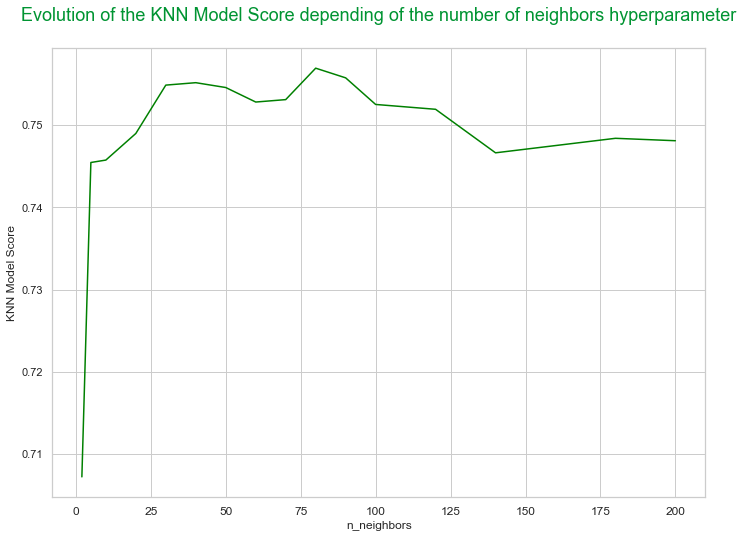

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.set_theme(style = "whitegrid")
ax = sns.lineplot(x = n_neighbors_list, y = scores_list, color = "green")
ax.set(xlabel = "n_neighbors", ylabel = "KNN Model Score")
plt.xticks(rotation = 0, size = 12, weight = 'normal')
plt.title("Evolution of the KNN Model Score depending of the number of neighbors hyperparameter\n", fontsize=18, color='#009432')
plt.show()

By a simple analysis of the graphic, we can se that the optimal number of neighbors is close to 80 (without touching the others parameters).

In [32]:
knn = KNeighborsClassifier(n_neighbors = 80)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7569077013521458

Conclusion